Importing the dependencies

In [1]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
print("Done")

Done


Creating the get_data_loader function to import the data from local directory. 

Working on preprocessed CelebA data cropped to show just the faces.


In [2]:
def get_data_loader(batch_size, image_size, data_dir='processed_celeba_small/'):
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    train_path = './' + data_dir
    
    train_dataset = datasets.ImageFolder(train_path, transform)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return train_loader

In [3]:
celebA_train_loader = get_data_loader(batch_size = 128,image_size =  (32, 32))

Visualizing the data


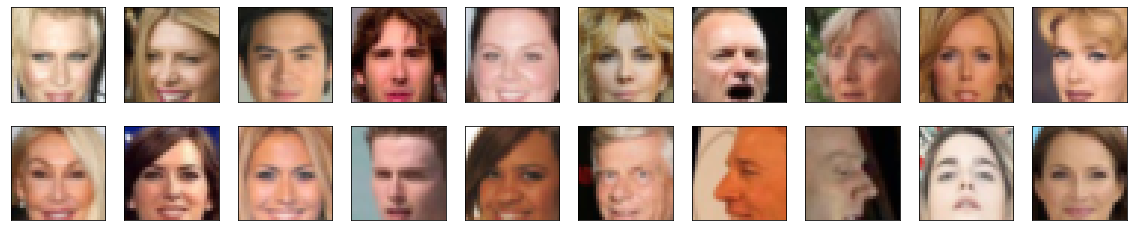

In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, _ = next(iter(celebA_train_loader))


fig = plt.figure(figsize=(20, 4))

plot_size=20

for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

Scaling the image data to suit the output of tanh activation in the Generator.

Range = (-1, 1)

In [5]:
def scale(x, feature_range = (1, -1)):
    
    a, b = 1, -1
    x = (a-b)*x + b
    
    return x

Defining conv and t_conv funtions to stack up layers of convolutions and transposed convolutions respectively

In [6]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride = 2, padding = 1, batch_norm = True):
    layers = []
    
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

def t_conv(in_channels, out_channels, kernel_size, stride = 2, padding = 1, batch_norm = True):
    layers = []
    
    t_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False)
    layers.append(t_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

Defining the Discriminator Network

In [7]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, 4, batch_norm = False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*4, 3, 1, 1)
        
        self.fc1 = nn.Linear(conv_dim*4*4*4, 512)
        self.fc2 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
         
        x = x.view(-1, self.conv_dim*4*4*4)
        
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

Defining the Generator Network

In [8]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        self.z_size = z_size
        
        self.fc1 = nn.Linear(z_size, 512)
        self.fc2 = nn.Linear(512, conv_dim*4*4*4)
        
        self.t_conv1 = t_conv(conv_dim*4, conv_dim*4, 3, 1, 1)
        self.t_conv2 = t_conv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = t_conv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = t_conv(conv_dim, 3, 4, batch_norm = False)
        
        
    def forward(self, x):
        x = x.view(-1, self.z_size)
        
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        
        x = x.view(-1, conv_dim*4, 4, 4)
        
        x = F.leaky_relu(self.t_conv1(x))
        x = F.leaky_relu(self.t_conv2(x))
        x = F.leaky_relu(self.t_conv3(x))
        x = torch.tanh(self.t_conv4(x))
         
        
        return x
    

Initializing Hyperparameters of model and creating model instances

In [9]:
conv_dim = 32
z_size = 128

D = Discriminator(conv_dim)
G = Generator(z_size, conv_dim)
print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2048, bias=Tr

Checking for GPU

In [10]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.') 

GPU available for training. Models moved to GPU


Defining Loss functions - Real Loss and Fake Loss

In [11]:
def real_loss(D_out, smoothing = False):
    
    batch_size = D_out.size(0)
    labels = torch.ones((batch_size))
    
    if smoothing:
        labels *= 0.9
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss


def fake_loss(D_out):
    
    batch_size = D_out.size(0)
    labels = torch.zeros((batch_size))
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss
    

Defining optimizers with required hyperparameters

In [12]:
import torch.optim as optim

lr = 0.002
beta1 = 0.5
beta2 = 0.999

D_optim = optim.Adam(D.parameters(), lr, [beta1, beta2])
G_optim = optim.Adam(G.parameters(), lr, [beta1, beta2])

Initializing training hyperparameters

In [13]:
num_epochs = 50

d = 2              
g = 1

print_every = 1

Training the Discriminator and Generator Networks

In [14]:
import pickle as pkl


samples = []
losses = []


sample_size = 8
fixed_z = np.random.uniform(-1, 1, size = (sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(celebA_train_loader):
    
        for e in range(d):
        
            batch_size = real_images.size(0)

            real_images = scale(real_images)

            D_optim.zero_grad()

            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()
                real_images = real_images.cuda()

            D_real = D(real_images)
            D_real_loss = real_loss(D_real)

            fake_images = G(z)
            D_fake = D(fake_images)
            D_fake_loss = fake_loss(D_fake)

            D_loss = D_real_loss + D_fake_loss
            D_loss.backward()
            D_optim.step()

        for e in range(g):
            
            G_optim.zero_grad()
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            D_fake = D(fake_images)
            G_loss = real_loss(D_fake)
            
            G_loss.backward()
            G_optim.step()
    if epoch%print_every == 0:        
        
        losses.append((D_loss.item(), G_loss.item()))
                
        print('Epoch [{:5d}/{:5d}] | D_loss: {:6.4f} | G_loss: {:6.4f}'.format(
                epoch+1, num_epochs, D_loss.item(), G_loss.item()))
            
    G.eval() 
    
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    
    samples_z = G(fixed_z)
    samples.append(samples_z)
    
    G.train() 

    
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)            

Epoch [    1/   50] | D_loss: 0.1731 | G_loss: 2.4538
Epoch [    2/   50] | D_loss: 0.0691 | G_loss: 3.8606
Epoch [    3/   50] | D_loss: 0.0911 | G_loss: 3.1021
Epoch [    4/   50] | D_loss: 0.0301 | G_loss: 4.6395
Epoch [    5/   50] | D_loss: 0.0772 | G_loss: 5.2492
Epoch [    6/   50] | D_loss: 0.1183 | G_loss: 4.2218
Epoch [    7/   50] | D_loss: 0.0662 | G_loss: 3.0625
Epoch [    8/   50] | D_loss: 0.0958 | G_loss: 4.0665
Epoch [    9/   50] | D_loss: 0.0040 | G_loss: 6.6815
Epoch [   10/   50] | D_loss: 0.0643 | G_loss: 4.7173
Epoch [   11/   50] | D_loss: 0.0307 | G_loss: 5.5246
Epoch [   12/   50] | D_loss: 0.1821 | G_loss: 5.9750
Epoch [   13/   50] | D_loss: 0.0485 | G_loss: 5.9916
Epoch [   14/   50] | D_loss: 0.0217 | G_loss: 4.8867
Epoch [   15/   50] | D_loss: 0.1943 | G_loss: 3.3736
Epoch [   16/   50] | D_loss: 0.0382 | G_loss: 5.9352
Epoch [   17/   50] | D_loss: 0.0244 | G_loss: 4.5402
Epoch [   18/   50] | D_loss: 0.0072 | G_loss: 5.0671
Epoch [   19/   50] | D_loss

Visualizing Loss on both networks over the epochs

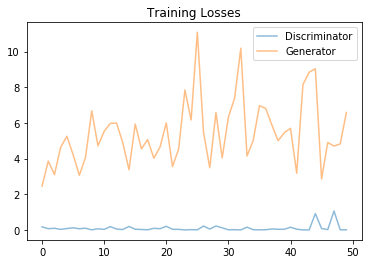

In [15]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [16]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,2), nrows=1, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

Visualizing the Generator outputs for the fixed_z over epochs

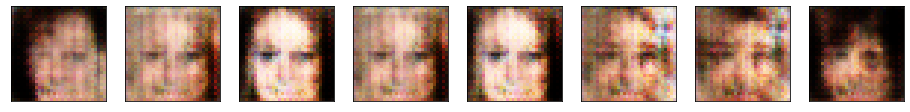

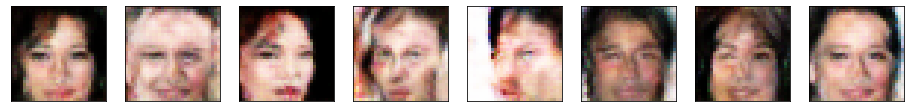

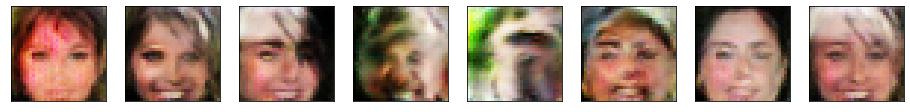

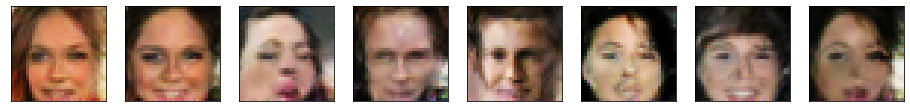

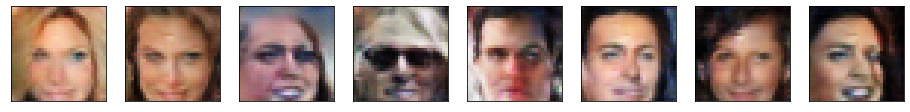

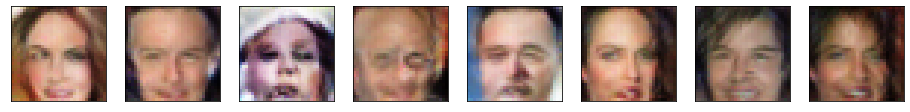

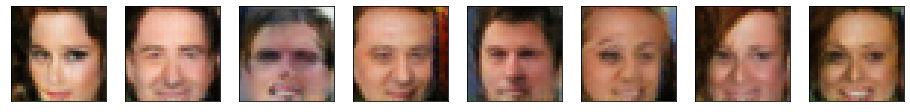

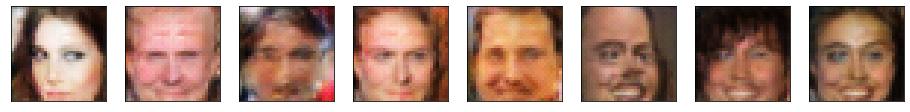

In [17]:
for i in range(0, num_epochs, 5):
    view_samples(i, samples)

Final results after last epoch

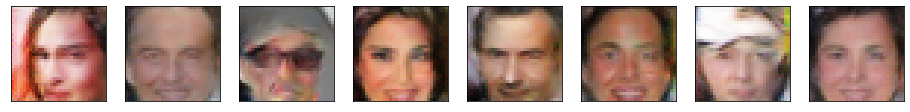

In [18]:
view_samples(-1, samples)